In [7]:
#%% Import
import numpy as np
import matplotlib.pyplot as plt

from mpmath import mp, findroot, j 
from mpmath import cosh, sinh, tanh, exp, sqrt
from scipy.optimize import curve_fit
import time

#The package must be installed through "conda install gwr_inversion"
from gwr_inversion import gwr 

## Functions and expressions declarations
def decaying_sinusoid(t, om_dec, om_osc):
    return np.exp(- om_dec * t)*np.cos(om_osc * t)

def my_exp(t, om_dec):
      return np.exp(- om_dec * t)
  
#Declare the expressions of the kernel and eta
def ker_sy (s, Oh, Bo, k, lbda):
    return 2*Oh/s*k*(k-lbda*tanh(k)) - Oh/s*(4*lbda*k*sinh(k)*(k*exp(-lbda)
            *(k*cosh(k)+lbda*sinh(k))-(k**2+lbda**2))+(k**2+lbda**2)**2
            *sinh(lbda))/(2*k*cosh(k)*(k*cosh(k)*sinh(lbda)-lbda*sinh(k)*cosh(lbda)))
            
def eta_sy (s, Oh, k, omega2, Kern):
    return 1/s*(1-omega2/(s**2+4*Oh*k**2*s+omega2+2*Oh*k**2*s*Kern))

#Reduce the expressions as functions of s and of the parameters Oh, Bo and k
def freeSurfaceLaplace(s, Oh, Bo, k):
    lbda = sqrt(k**2 + s/Oh)
    omega2 = (Bo+k**2)*k*tanh(k)
    ker = ker_sy (s, Oh, Bo, k, lbda)
    return eta_sy(s, Oh, k, omega2, ker)

def denom (s, Oh, Bo, k):
    lbda = sqrt(k**2 + s/Oh)
    omega2 = (Bo+k**2)*k*tanh(k)
    ker = ker_sy (s, Oh, Bo, k, lbda)
    return (s**2+4*Oh*k**2*s+omega2+2*Oh*k**2*s*ker)

#Inverse the Laplace transfrom and return the values of eta as a function 
#of a range of t and the parameters Oh, Bo and k
def freeSurface(t_all, Ohnumb, Bonumb, knumb, M_value = 32):
    store = time.time()
    Oh = mp.mpmathify(Ohnumb)
    Bo = mp.mpmathify(Bonumb)
    k = mp.mpmathify(knumb) 
    f = lambda s: freeSurfaceLaplace(s, Oh, Bo, k)
    a = [float(gwr(f, t, M_value)) for t in t_all]
    print (time.time()-store)
    return a

#Calculation of the different growth rates and pulsations
def om_lub(Oh, Bo, k):
    return (k**2*Bo+k**4)/(3*Oh)

def pulsation(Bo, k):
    return np.sqrt(np.abs(Bo + k**2)*k*np.tanh(k))

## Parameters figures
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage[squaren,Gray]{SIunits} \usepackage{nicefrac}'

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
#font size
plt.rc('font', size=10)  # general font size
plt.rc('axes', labelsize=10, titlesize=10)
plt.rc('lines', markersize=8, markeredgewidth=0., linewidth=0.4)
plt.rc('legend', frameon=False, fancybox=False, numpoints=1, markerscale=1, 
       fontsize=10, handlelength=0.6, handletextpad=0.6, labelspacing=0.3)
plt.rc('xtick',  labelsize=8, direction='in', bottom='true', top='true')
plt.rc('ytick',  labelsize=8, direction='in', left='true', right='true')
plt.rc('savefig', bbox='tight', transparent=True, dpi=300) 

4.716969728469849
4.909440755844116


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


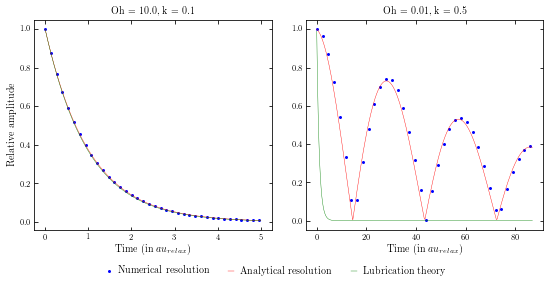

In [2]:
#%% Figure 1
#Comparison between lubrication, analytical and numerical results for 2 different situations : oscillations and relaxation
def om_analytic(Oh, Bo, k):
    try:
        root_denom = findroot(lambda s: denom (s, Oh, Bo, k), om_lub(Oh, Bo, k))
    except ValueError:
        root_denom = findroot(lambda s: denom (s, Oh, Bo, k), j*pulsation(Bo, k))
    return root_denom

def plotHeight(Oh, Bo, k, ax):
    om_relax = om_lub(Oh, Bo, k)
    om_0 = pulsation(Bo, k)
    om_ana = om_analytic(Oh, Bo, k)/om_relax
    
    t_all = np.linspace(0.0001, 1., 300) * max(abs(5./om_relax), 10./om_0)
    sampled_t = abs(t_all*om_relax)
    sampled_eta = freeSurface(t_all[::8], Oh, Bo, k)
    sampled_eta_lub = np.exp(-t_all*om_relax)
    
    ax.set_title("Oh = " + str(Oh) + ", k = " + str(k))
    ax.plot(sampled_t[::8],np.abs(sampled_eta), '.b', ms = 6., label = r'Numerical resolution')
    ax.plot(sampled_t, np.abs(decaying_sinusoid(sampled_t, float(-mp.re(om_ana)), float(mp.im(om_ana)))), 'red', label = 'Analytical resolution')
    ax.plot(sampled_t,sampled_eta_lub, 'green', label = 'Lubrication theory')
    ax.set_xlabel('Time (in $\tau_{relax}$)')
    
fig, ax = plt.subplots(ncols = 2, figsize=(8, 4))
plotHeight(10., 0.001, 0.1, ax[0])
plotHeight(0.01, 0.001, 0.5, ax[1])

lines, labels = ax[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc = 'lower center', borderaxespad=0.1, ncol=3)
ax[0].set_ylabel('Relative amplitude')
plt.tight_layout(pad=2.)


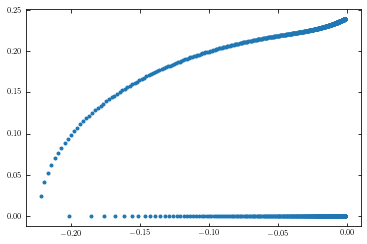

In [3]:
#%% Figure 2
Bo = 0.001
k = 0.5
Oh_list = np.logspace(-4, 1, 1000)
om_ana = []
root_denom = j*pulsation(Bo, k)

for Oh in Oh_list:
    root_denom = findroot(lambda s: denom (s, Oh, Bo, k), root_denom)
    om_ana.append([float(mp.re(root_denom)), float(mp.im(root_denom))])
om_ana = np.array(om_ana)

plt.figure()
plt.plot(om_ana[:,0], om_ana[:,1], '.')

C:\Users\C6139404\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide


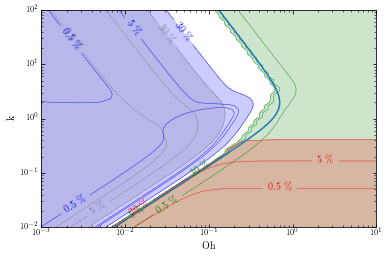

In [4]:
#%% Figure 3
# Relative error of different models compare to the numerical results.

#Asymptotic solutions obtained from the normal mode in Cortelezzi's derivation
def om_normal_mode_viscous(Oh, Bo, k):
    return -pulsation(Bo, k)**2/(k**2*Oh*np.tanh(k))*(k-np.cosh(k)*np.sinh(k))/(1+2*k**2+np.cosh(2*k))
    
def puls_normal_mode_inertial(Oh, Bo, k):
    return pulsation(Bo, k) - (1/np.sinh(2*k)*np.sqrt(pulsation(Bo, k) * k**2*Oh/2)
            - pow(k**2*Oh,3./2.)/np.sqrt(2*pulsation(Bo, k))
            *(3-8*np.cosh(2*k)-14*np.cosh(4*k)+4*np.cosh(6*k))/(8*np.sinh(2*k)**3)) 

def om_normal_mode_inertial(Oh, Bo, k):
    return (1/np.sinh(2*k)*np.sqrt(pulsation(Bo, k) * k**2*Oh/2) +
            2*k**2*Oh * (np.cosh(4*k)+np.cosh(2*k)-1) / (np.cosh(4*k) -1)
            - pow(k**2*Oh,3./2.)/np.sqrt(2*pulsation(Bo, k))
            *(3-8*np.cosh(2*k)-14*np.cosh(4*k)+4*np.cosh(6*k))/(8*np.sinh(2*k)**3)) 

#Growth rate and pulsations obtained by fit of the numerical solution.
def om_numerical(Oh, Bo, k):
    om_0 = puls_normal_mode_inertial(Oh, Bo, k)
    if (Oh < pulsation(Bo, k)/(k**2/0.7+1/0.6)):
        M = 64
        om_relax = om_normal_mode_inertial(Oh, Bo, k)
        t_all = np.linspace(0.01, 1., 100) * min(50./om_0, abs(5./om_relax)) 
    else:
        M = 32
        om_relax = om_normal_mode_viscous(Oh, Bo, k)
        t_all = np.linspace(0.01, 1., 40) * abs(5./om_relax)
        
    sampled_eta = freeSurface(t_all, Oh, Bo, k, M)
    if min(sampled_eta) < 0:
        popt = curve_fit(decaying_sinusoid, t_all, sampled_eta, p0=(om_relax, om_0), bounds=(0,[np.inf, 2*om_0]))[0]
    else:
        popt = [curve_fit(my_exp, t_all, sampled_eta, p0=(om_relax))[0][0], 0]
    return popt, t_all, sampled_eta

#Compare the different models for a range of Oh and k.
def plotErrorOm (Oh_list, k_list, Bo, file_name, compute = False):
    #The data can be easily recompute but it takes about 1h.
    #For time efficiency, numerical values are by default taken in the txt file. 
    if compute:
        om_num = [[[0, pulsation(Bo, k)] for k in k_list]]
        for Oh in Oh_list:
            om_num.append([om_numerical(Oh, Bo, k)[0] for k in k_list])
        om_num = np.transpose(np.array(om_num[1:]))
        np.save(file_name,om_num)
        
    #Numerical decaying rate and pulsation
    om_num = np.load(file_name)
    relax_num = om_num[0] # 0 for decaying
    puls_num = om_num[1] # 1 for oscillation
    
    #Analytical decaying rate and pulsation
    err_relax = np.abs(np.array([[om_lub(Oh, Bo, k) for Oh in Oh_list] for k in k_list])/relax_num-1)
    err_puls = np.abs(np.array([[puls_normal_mode_inertial(Oh, Bo, k) for Oh in Oh_list] for k in k_list])/puls_num-1)
    inert_domain = 1e6*np.array([[(Oh > pulsation(Bo, k)/(k**2/0.7+1/0.8)) for Oh in Oh_list] for k in k_list])
    err_in = (np.array([[om_normal_mode_inertial(Oh, Bo, k) for Oh in Oh_list] for k in k_list])/relax_num-1) + inert_domain
    err_visc = np.abs(np.array([[om_normal_mode_viscous(Oh, Bo, k) for Oh in Oh_list] for k in k_list])/relax_num-1)

    #Figure parameter and contour's labels
    plt.figure()
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Oh')
    plt.ylabel('k')
    
    fmt = {}
    for l, s in zip([0.005, 0.05, 0.3], ['0.5 \%', '5 \%', '30 \%']):
        fmt[l] = s
        
    #Plot contour lines and fillings
    for err, c in zip([err_puls, err_visc, err_relax, err_in],['grey', 'green', 'red', 'blue']):
        plt.contourf(Oh_list, k_list, err, levels = [-0.3, 0.3], colors = c, alpha = 0.2);
        cs = plt.contour(Oh_list, k_list, err, levels = [0.005, 0.05, 0.3], colors = c);
        plt.clabel(cs, fmt=fmt, fontsize=10)
    x = [pulsation(Bo, k)/(k**2/1.3115+1/0.732) for k in k_list]
    plt.plot(x, k_list, linewidth = 1.5)

Oh_list = np.logspace(-3, 1, 60)
k_list = np.logspace(-2, 2, 60)
Bo = 1
plotErrorOm (Oh_list, k_list, Bo, 'fig3_om_num.npy', False)

# #%% Visu_Figure 3
# # Not for the article : vue of the curve-fitting and comparison with models for different k, Oh.
# def plotGrowtRate(Oh, Bo, k, ax): 
#     om_num, t_all, sampled_eta = om_numerical(Oh, Bo, k)
#     if (Oh < pulsation(Bo, k)/(k**2/0.7+1/0.6)):
#         om_relax = om_normal_mode_inertial(Oh, Bo, k)
#     else: 
#         om_relax = om_normal_mode_viscous(Oh, Bo, k)
#     sampled_t = abs(t_all*om_relax)
    
#     ax.set_title(np.round(om_relax/om_num[0]-1,5))
#     ax.plot(sampled_t, np.abs(sampled_eta), 'black', label = r'Numerical resolution')
#     ax.plot(sampled_t, np.exp(- t_all * om_num[0]), 'red', label = 'Decaying')
#     ax.plot(sampled_t, np.abs(np.exp(- om_num[0] * t_all)*np.cos(om_num[1] * t_all)), 'blue', label = 'Decaying')
#     ax.set_ylim([0,1])
#     return om_num

# Bo = 1
# Oh = np.logspace(-3, 0, 4)
# k = np.logspace(-2, 2, 5)

# fig, ax = plt.subplots(ncols = len(Oh), nrows = len(k), figsize=(9, 9))

# om_num = [[0,pulsation(Bo, k0)] for k0 in k]
# for l in range(len(Oh)):
#     om_num = [plotGrowtRate(Oh[l], Bo, k[i], ax[len(k)-1-i,l]) for i in range(len(k))]


1.9750633239746094
2.0555260181427
1.9210190773010254
1.8974807262420654
1.7873976230621338
1.8030316829681396
1.6736729145050049
1.8760669231414795
3.3730661869049072
2.024266004562378
1.9199674129486084
3.3361074924468994
4.411311149597168
5.554999351501465
3.0841405391693115
2.740124464035034
3.0842366218566895
2.634941816329956
2.6841752529144287
3.203742027282715
2.457139492034912
2.4775636196136475
2.736816883087158
2.950002431869507
2.4919300079345703
2.622441530227661
2.8581533432006836
2.643005132675171
2.556851625442505
2.6338424682617188
2.757664203643799
3.343193531036377
3.1797337532043457
3.3330132961273193
2.6554808616638184
2.486217737197876
2.4485533237457275
2.877518892288208
2.5384273529052734
2.4994008541107178
2.510122776031494
2.5360569953918457
2.7984161376953125
1.7938854694366455
1.749743938446045
1.8673148155212402
1.785797357559204
1.722395896911621
1.841860055923462
1.755784034729004
1.8790321350097656
1.6898353099822998
1.7709438800811768
1.7091307640075684

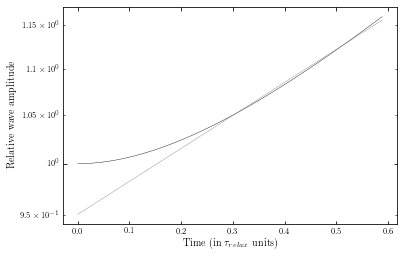

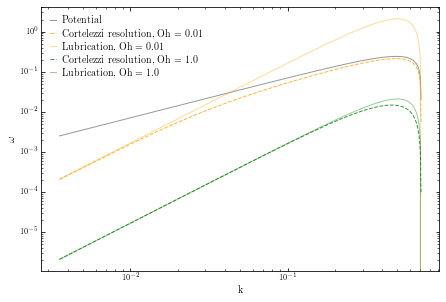

In [8]:
#%% Figure 4 
#Rayleigh-Taylor
from scipy import stats

def growth_rate(Oh, Bo, k):
    t_all = np.linspace(0.001, 25., 50)/k
    sampled_eta = freeSurface(t_all, Oh, Bo, k)
    
    reg = stats.linregress(t_all[20:], np.log(sampled_eta[20:]))
    if (reg[2]<0.999):
        print(Oh, k, reg[2])
        plt.figure()
        plt.xlabel(r'Time (in $\tau_{relax}$ units)')
        plt.ylabel("Relative wave amplitude") 
        plt.semilogy(t_all*abs(om_lub(Oh, Bo, k)), sampled_eta, 'black', label = r'Cortelezzi \& Prosperetti')
        plt.semilogy(t_all*abs(om_lub(Oh, Bo, k)), np.exp(reg[1] + t_all*reg[0]), 'gray', label = 'Regression')
    return reg[0]

Bo = -0.5
Oh_list = [0.01, 1.]
k_list = np.linspace(0.005, 0.999, 100) * np.sqrt(-Bo)
k_list2 = np.linspace(0.005, 1., 100) * np.sqrt(-Bo)

om_gwr_Oh = []
om_lub_Oh = []
for Oh in Oh_list:
    om_gwr_Oh.append([growth_rate(Oh, Bo, k) for k in k_list])
    om_lub_Oh.append([np.abs(om_lub(Oh, Bo, k)) for k in k_list2])
om_potential = [pulsation(Bo, k) for k in k_list]
Colors = ['orange', 'green', 'black']

plt.figure()
plt.xlabel(r'k')
plt.ylabel(r'$\omega$')
plt.loglog(k_list, om_potential, lw=1.0, alpha = 0.4, color = Colors[-1], label = r'Potential')
for Oh, om_gwr, om_lub, c in zip(Oh_list, om_gwr_Oh, om_lub_Oh, Colors):
    plt.plot(k_list, np.abs(om_gwr), '--', lw=1.0, color = c, alpha = 0.8, label = r'Cortelezzi resolution, Oh = ' + str(Oh))
    plt.plot(k_list2, om_lub, '-', lw=1.0, alpha = 0.4, color = c, label = 'Lubrication, Oh = ' + str(Oh))
plt.legend()
plt.tight_layout(pad=0.)